# Simulating a Multilevel Model
In the previous part of this lesson, we explored the multilevel framework from a purely theoretical and formal perspective. However, it can be tricky to wrap your head around all this, especially when you are not used to think in terms of multiple levels of variation. To try and help with this, we will explore *simulating* a multilevel model in `R`. This will serve two purposes. Firstly, it can be useful to see some code when trying to understand an abstract representation of a model. Secondly, there are some not-so-obvious consequences of the multilevel framework that make it particularly suited for repeated measurements. Although we could just state these consequences, the hope is that they are more concrete when actually seen as an emergent property of the multilevel framework.

## Simulation Code
The code for the simulations is given below. This is a direct implementation of the multilevel model visualised back in {numref}`multilevel-fig`. You can spend time studying it and making the connections with the mathematical notation if you wish. However, the more important aspect is examining the *output*, so try not to get too side-tracked here.

In [1]:
set.seed(666)

#================================================================#
# Setup
#================================================================#

# simulation size
n.subs <- 10000                     # big N
n.t    <- 3                         # 3 repeated measures

# fixed-effects
mu    <- 5                          # group-level grand mean
alpha <- c(-2,1,3)                  # repeated measures effects

# variances
sigma2.1 <- 3                       # Level 1 (within-subject)
sigma2.2 <- 2                       # Level 2 (between-subjects)

# empty matrix for y (N x T)
y <- matrix(nrow=n.subs, ncol=n.t)

#================================================================#
# Run the simulations
#================================================================#

#----------------------------------------------------------------#
# Level 2 
#----------------------------------------------------------------#
# mu[i] ~ N(mu,sigma2.2)
#----------------------------------------------------------------#

mu.i <- rnorm(n.subs, mean=mu, sd=sqrt(sigma2.2))

#----------------------------------------------------------------#
# Level 1 
#----------------------------------------------------------------#
# y[ij] ~ N(mu[i] + alpha[j], sigma2.1)
#----------------------------------------------------------------#

for (i in 1:n.subs){
  for (j in 1:n.t){
    y[i,j] <- rnorm(n=1, mean=mu.i[i] + alpha[j], sd=sqrt(sigma2.1))
  }
}

## Level 2 Distribution

To begin with, let us have a look at the simulated distribution of subject means. This is the Level 2 distribution, illustrated back in {numref}`multilevel-fig`.

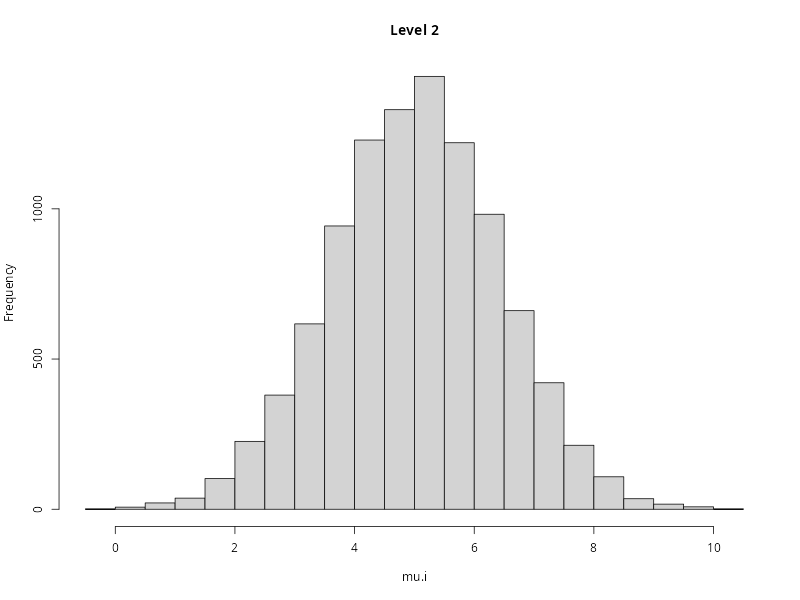

In [2]:
hist(mu.i, main='Level 2')

This represents our *population* of subjects. Each values on the $x$-axis represents an average value of our outcome variable for each subject. If we take one value from this distribution, we are sampling a *single* subject as a whole. The *width* of this distribution therefore represents variation *between* the subjects. It tells us how much we expect the subjects to differ from each other on average. In the simulations, we set $\sigma^{2}_{2} = 2$ and indeed we find that

In [3]:
var(mu.i)

[1] 1.999054

which is basically 2. Importantly, the elements of this distribution are taken as *independent* because each subject is assumed not to influence the response given by any other subject. This is implicit in the simulations because the vector of subject means are created as *independent* random draws from a normal distribution. In reality, this is an *assumption*, though usually a fairly reasonable one. 

## Level 1 Distributions
Next, let us focus on the Level 1 simulations. For this example, we only simulated *one value* per-subject and per-repeated measurement. Because of this, we have no way of *seeing* the Level 1 distributions from {numref}`multilevel-fig`. All we have is a single value from each one. So, what we can do instead is create some examples of these distributions by re-drawing a large number of simulated values. In the code below, we choose some random subject indices and then, for each of these subject, simulate 5,000 values from their distribution for each time-point. The results of doing this are shown in the plots below. The three example subjects are given in the columns, with the distributions for time-point shown in rows. These are now examples of the the Level 1 distributions from {numref}`multilevel-fig`. In that illustration, we used $t = 2$, but in the simulations we have used $t = 3$ just to show how the framework generalises to any number of repeated measurements. 

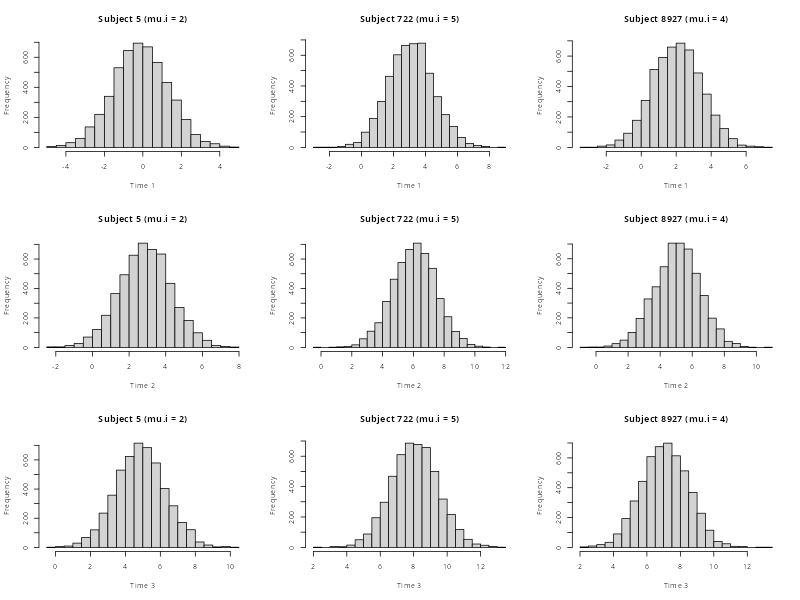

In [6]:
subs <- c(5,722,8927) # random subject numbers
n    <- length(subs)  # number of subjects

par(mfrow=c(3,n))

# plot each distribution
for (j in 1:3){
  for (i in 1:n){

    # subject index
    sub.idx  <- subs[i]

    # Level 1 distribution
    sub.dist <- rnorm(n=5000, mean=mu.i[sub.idx] + alpha[j], sd=sqrt(sigma2.2))
    
    # plot the distribution
    hist(sub.dist, main=paste0('Subject ', sub.idx, ' (mu.i = ', round(mu.i[sub.idx]), ')'),
         xlab=paste0('Time ', j), breaks=20)
  }
}

There are some key things to notice here. Firstly, each subject has a different scaling along the $x$-axis, even under the the same conditions. So these three subjects do differ in terms of their measurements, even at the same time-point. However, we conceptualise this as a combination of a *subject-specific mean* and a *universal effect of time*. For instance, notice that the mean of each distribution for Time 1 is always 2 below the mean of the subject. So, Subject 5 has $\mu_{i} = 2$ and their average response in Time 1 is $2 - 2 = 0$. Similarly, Subject 722 has $\mu_{i} = 5$ and their average response in Time 1 is $5 - 2 = 3$. So, no matter the subject, their response can be conceptualised as their own personal mean *plus* a constant effect of time. This captures the idea that, even though the subject responses all appear different, we can still learn about the effects of time by pooling information from across them.

## Final Simulated Data
Finally, let us have a look at the actual data that has been simulated *across* all the subjects. This has been generated as a *combination* of both levels and thus both levels will contribute to what we will see. The final distributions are what we imagine we are measuring in our experiment, so they can be thought of as the distributions we are sampling from within each cell of our design. Using the code above, this results in 10,000 simulated values for each time-point, as shown in the histograms below.

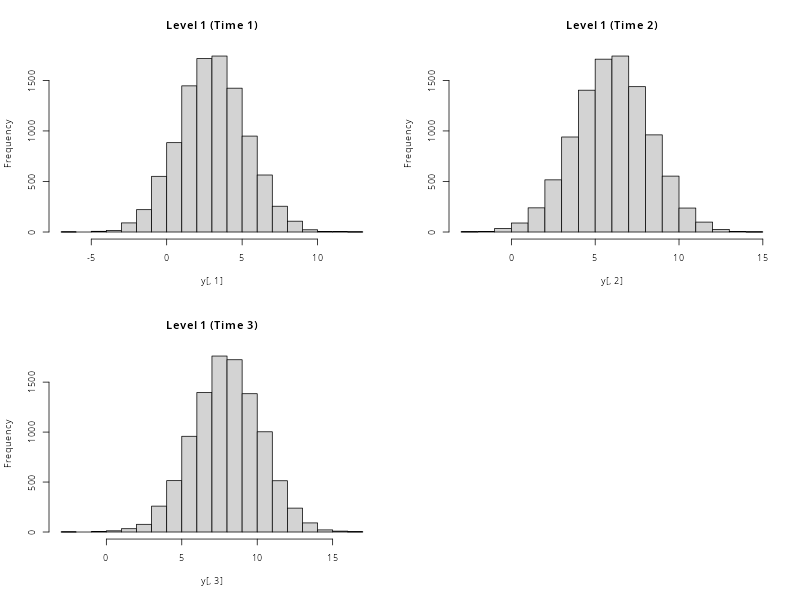

In [7]:
par(mfrow=c(2,2))
hist(y[,1], main='Level 1 (Time 1)')
hist(y[,2], main='Level 1 (Time 2)')
hist(y[,3], main='Level 1 (Time 3)')
par(mfrow=c(1,1))

To understand these distributions, we will focus on `Level 1 (Time 1)`, which is shown in isolation below. 

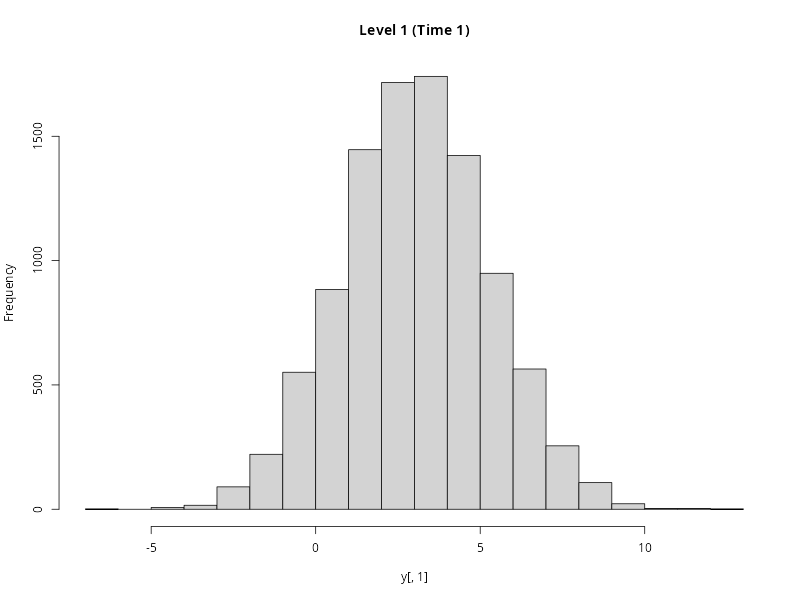

In [8]:
hist(y[,1], main='Level 1 (Time 1)')


The mean of this distribution is

In [9]:
mean(y[,1])

[1] 3.051811

Where does this value come from? Well, on average we expect the subject means to be equal to $\mu$, because this is the mean of the Level 2 distribution. In the simulations we set $\mu = 5$, so the average subject from the population should have a mean equal to 5. Then, we set the fixed effect for Time 1 to be $\alpha_{1} = -2$. So the true deviation from the mean for Time 1 is equal to -2. So, on average a subject from this population will have a mean of 5, which will reduce by 2 during Time 1. So, our distribution for Time 1 has a mean of $5 + (-2) = 3$, which is exactly what we see. Importantly, this is a product of *both levels* of the data-generating process. This is how the data are formed from Level 1 *and* Level 2 combined. 

We can also see this formally, rather than relying on simulation. If we work out the expected value of our data, given our model, we get

$$
\begin{alignat*}{1}
    E(y_{ij}) &= E(\mu_{i}  + \alpha_{j} + \eta_{ij}) \\ 
              &= E(\mu_{i}) + E(\alpha_{j}) + E(\eta_{ij}) \\
              &= E(\mu_{i}) + \alpha_{j} \\ 
              &= \mu        + \alpha_{j}.
\end{alignat*}
$$

Because $\alpha_{j}$ is a *constant*, its expected value is just equal to itself. Its value never changes, so its average over repeated sampling is just equal to its original value. $\eta_{ij}$ is error with $E(\eta_{ij}) = 0$, so it falls-out. This only leaves the expected value of $\mu_{i}$, which comes from the Level 2 distribution whose mean is $\mu$. Hence $E(\mu_{i}) = \mu$.

What about its variance? We can calculate this from the simulations

In [ ]:
var(y[,1])

Where does this come from? ...

Again, we can state this formally as

$$
\begin{alignat*}{2}
    \text{Var}(y_{ij}) &= \text{Var}(\mu_{i} + \alpha_{j} + \eta_{ij}) \\
                       &= \text{Var}(\mu_{i} + \eta_{ij}) \\
                       &= \text{Var}(\mu_{i}) + \text{Var}(\eta_{ij}) &\quad\text{(assuming independence)}  \\
                       &= \sigma^{2}_{1} + \sigma^{2}_{2} 
\end{alignat*}
$$

where $\alpha_{j}$ disappears because it is a *fixed constant* and thus does not contribute to the variance. So, *both* the mean and the variance of the final data are a *combination* of both levels. Both levels *feed-in* to the data and thus we can understand complex data by separating it out into multiple levels of variation that combine to produce what we are actually measuring.

## Covariance Structure of the Simulated Data
Now, for the party trick. Let us calculate the variance-covariance matrix of the simulated repeated measurements

In [ ]:
var(y)

Notice anything familiar here? For starters, the simulated values of `time` are *correlated*. This is not necessarily surprising, except for the fact that *we did not simulate any correlation*. There is no multivariate normal distribution with a given correlation structure anywhere in the code above. So where did the correlation come from? This is actually a *natural consequence* of the algebra of a multilevel model. We do not need to specify correlation because it happens *automatically* as part of the connection between the levels of the model. This feels a bit like a magic trick, but we can see it clearly above.  

- Multilevel structure creates correlation naturally, without specifying any form of variance-covariance matrix
- Diagonal elements are $\sigma^{2}_{1} + \sigma^{2}_{2} = 2 + 3 = 5$
- Off-diagonal elements are $\sigma^{2}_{1} = 2$
- This structure implies a compound-symmetric covariance matrix

[^xi-foot]: The Greek letter *xi*.

[^levels-foot]: Level 2 in *this* model. In general, the levels of a multilevel model do not have any meaning outside of a given dataset or context. They are just labels for the levels the model happens to have. So, the normal linear model has just *one level* and it would not make sense to talk about this as "Level 2" outside of the current context of comparing it to the multilevel model described above.

[^gelman-foot]: This is exactly the perspective taken by Gelman & Hill (2007) in their book [*Data Analysis Using Regresion and Multilevel/Hierarchical Models*](https://sites.stat.columbia.edu/gelman/arm/). Everything is effectively a regression model with one or more levels.